# CWT & STFT + CNN Model with BCI_competitionIII dataset

In [1]:
import mne
import numpy as np
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from scipy.io import loadmat

epochs = [0] *5

for j in range(1,6):
    mat_data = loadmat('D:\BCI_competitionIII\BCI_100Hz\S' + str(j) + '_data_set')

    channels = []
    for i in range(0,118):
        channels.append(mat_data['nfo']['clab'][0][0][0][i][0])

    fs = mat_data['nfo']['fs'][0][0][0][0]
    events_index = mat_data['mrk']['pos'][0][0][0]

    events_labels = mat_data['mrk']['y'][0][0][0]
    events_labels= np.nan_to_num(events_labels, nan=0.0)

    info = mne.create_info(
        ch_names= channels,
        ch_types= ['eeg']*len(channels),
        sfreq= fs
    )

    info.set_montage('standard_1005', on_missing= 'ignore')
    ev = [i*fs*5 for i in range(len(events_labels))]
    events = np.column_stack((np.array(ev, dtype = int),
                            np.zeros(len(events_labels), dtype = int),
                            np.array(events_labels, dtype = int)))

    cnt = mat_data['cnt'] *0.1
    cnt = cnt.T

    data = []
    for i in range(0,len(events_labels)):
        if i <= 278:
            # print(np.shape(cnt[:,events_index[i]:events_index[i+1]]))
            data.append(cnt[:,events_index[i]:events_index[i] + (fs*5)])
        else:
            # print(np.shape(cnt[:,events_index[i]:len(cnt[0])]))
            data.append(cnt[:,events_index[i]:events_index[i]+ (fs*5)])

    data = np.asanyarray(data)

    t_min = 0.0
    t_max = 3.5
    event_id = dict(Right= 1, Foot= 2, no=0)
    epochs[j-1] = mne.EpochsArray(data, info, events,t_min, event_id, baseline=None)
    epochs[j-1] = epochs[j-1].copy().crop(tmin=0.0, tmax=3.5)
    epochs[j-1] = epochs[j-1].pick(['C3','Cz','C4'])
    # epochs[j-1] = epochs[j-1].pick(['FC3','C5','CP3','C3','Cz','C4','C6','FC4','CP4'])
    epochs[j-1] = epochs[j-1].copy().filter(l_freq=4.0, h_freq=35.0, method = 'iir', iir_params= {"order": 16, "ftype":'butter'})
    epochs[j-1] = epochs[j-1].copy().set_eeg_reference(ref_channels="average")

Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 4 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 64 (effective, after forward-backward)
- Cutoffs at 4.00, 35.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 4 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 64 (effective, after forward-backward)
- Cutoffs at 4.00, 35.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
280

In [2]:
# combine_epochs = mne.concatenate_epochs([epochs[0], epochs[1], epochs[2], epochs[3], epochs[4]])
combine_epochs = mne.concatenate_epochs([epochs[1]])
del epochs

Not setting metadata
280 matching events found
No baseline correction applied


In [3]:
print(np.shape(combine_epochs['Right','Foot']))
labels = combine_epochs['Right','Foot'].events[:,2]

(224, 3, 351)


In [4]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Activation
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import History 
history = History()
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from ssqueezepy import ssq_cwt, ssq_stft

In [5]:
combine_epochs['Right','Foot'].get_data().shape[2]

351

In [6]:
shape = np.shape(combine_epochs['Right','Foot'].get_data())
train_data = np.ndarray(shape=(shape[0], shape[2], shape[1]))

for jj in range(0, shape[0]):
    train_data[jj] = combine_epochs['Right','Foot'].get_data()[jj].T
    
print(np.shape(train_data))

(224, 351, 3)


In [7]:
# train_data = combine_epochs['Right','Foot'].get_data().reshape(shape[0], shape[2], shape[1])
print(np.shape(train_data))
scales = range(4,36)

scales = np.array(scales)
scales = scales.astype('float32')

waveletname = 'morl'
train_size = len(labels)
train_data_cwt = np.ndarray(shape=(train_size, 32,227,3))

for ii in range(0,train_size):
    if ii % 40 == 0:
        print(ii)
    for jj in range(0,3):
        signal = train_data[ii, :, jj]
        # _,coeff, *_ = ssq_cwt(signal)
        # _ ,coeff, *_ = ssq_stft(signal, n_fft = 226*2)
        coeff, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:227]  #crop 227 sample for each channel
        train_data_cwt[ii, :, :, jj] = abs(coeff_)
print(np.shape(coeff),np.shape(coeff_))

(224, 351, 3)
0
40
80
120
160
200
(32, 351) (32, 227)


In [8]:
print(np.shape(coeff), np.shape(coeff_))

(32, 351) (32, 227)


In [9]:
print(np.shape(signal))
print(np.shape(coeff))
print(np.shape(coeff_))
print(np.shape(train_data_cwt))

(351,)
(32, 351)
(32, 227)
(224, 32, 227, 3)


In [20]:
x_train, x_test, y_train, y_test = train_test_split(train_data_cwt, labels, test_size=0.2, random_state=42)

img_x = 32
img_y = 227
img_z = 3
num_classes = 2

batch_size = 1
epochs = 100
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

# del train_data_cwt
# del combine_epochs
# plt.imshow(x_train[0,:,:,1], aspect='auto', cmap='turbo')
# plt.show()
# plt.imshow(x_train[2,:,:,1], aspect='auto', cmap='turbo')
# plt.show()
y_train = keras.utils.to_categorical(y_train - 1, num_classes)
y_test = keras.utils.to_categorical(y_test -1 , num_classes)
input_shape = (img_x, img_y, img_z)

(179, 32, 227, 3) (45, 32, 227, 3) (179,) (45,)


In [21]:
# Define the model
model = Sequential()

# Input Layer (I1)
model.add(Input(shape=input_shape))

# Convolution Layer (C2)
model.add(Conv2D(8, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Convolution Layer (C3)
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Flatten Layer (F4)
model.add(Flatten())

# Fully Connected Layer (D5)
model.add(Dense(64))

# Output Layer (O6)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(learning_rate= 0.01), 
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[history])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 227, 8)        224       
                                                                 
 batch_normalization_4 (Bat  (None, 32, 227, 8)        32        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 32, 227, 8)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 227, 16)       1168      
                                                                 
 batch_normalization_5 (Bat  (None, 32, 227, 16)       64        
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 32, 227, 16)      

KeyboardInterrupt: 

In [12]:
# model = Sequential()
# # Layer 1: Convolutional + Max-Pooling
# model.add(Conv2D(filters= 96, kernel_size= (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D((3, 3), strides=(2, 2)))

# # Layer 2: Convolutional + Max-Pooling
# model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1) ,activation='relu', padding= 'valid'))
# model.add(MaxPooling2D((3, 3), strides=(2, 2), padding= 'valid'))

# # Layer 3: Convolutional
# model.add(Conv2D(filters =384, kernel_size= (3, 3), strides=(1,1),activation='relu', padding= 'valid'))

# # Layer 4: Convolutional
# model.add(Conv2D(filters = 384, kernel_size= (3, 3), strides=(1,1),activation='relu', padding= 'valid'))

# # Layer 5: Convolutional + Max-Pooling
# model.add(Conv2D(filters = 256, kernel_size= (3, 3), strides=(1,1),activation='relu', padding= 'valid'))
# model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='valid'))

# # Flatten the output for fully connected layers
# model.add(Flatten())

# # Layer 6: Fully Connected (Dense)
# model.add(Dense(4096, activation='relu', input_shape = (13,13,128)))
# model.add(keras.layers.Dropout(0.4))

# # Layer 7: Fully Connected (Dense)
# model.add(Dense(2048, activation='relu'))
# model.add(keras.layers.Dropout(0.4))

# # Layer 8: Output Layer
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss=keras.losses.categorical_crossentropy, 
#               optimizer=keras.optimizers.Adam(learning_rate= 0.0001), 
#               metrics=['accuracy'])

# model.fit(x_train, y_train, batch_size=batch_size, 
#           epochs=epochs, verbose=1, 
#           validation_data=(x_test, y_test), 
#           callbacks=[history])

In [13]:
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train loss: 0.013464977033436298, Train accuracy: 0.994413435459137
Test loss: 22.271141052246094, Test accuracy: 0.6666666865348816


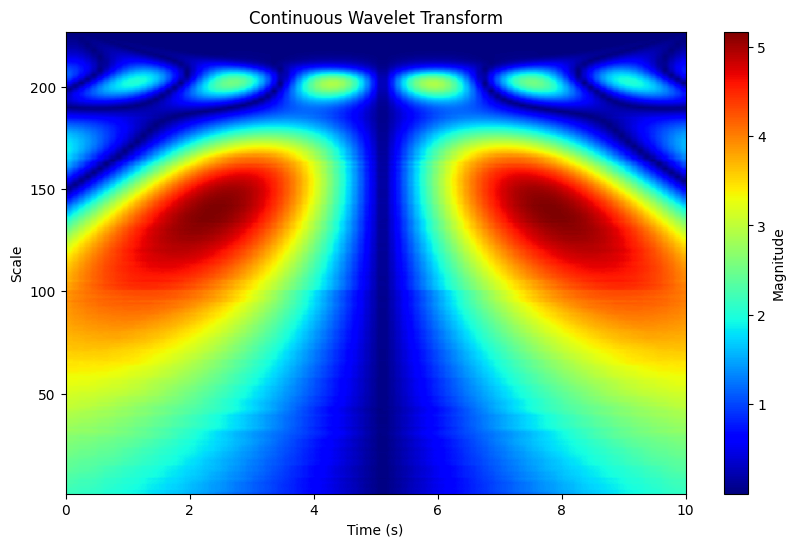

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Create a sample signal
window_size = 1.0  # seconds
step_size = 0.25  # seconds

t = np.arange(0, 1, 0.01)
signal = np.sin(2 * np.pi * t) + 0.5 * np.sin(6 * np.pi * t)


# Calculate the scales for the CWT
sample_rate = 1 / (t[1] - t[0])
scales = np.arange(1, int(window_size * 227) + 1)

# Initialize an empty array to store the CWT coefficients
cwt_result = np.zeros((len(scales), len(t)))

# Compute the CWT
for i, scale in enumerate(scales):
    # print(i)
    coefficients, _ = pywt.cwt(signal, [scale], 'morl')
    cwt_result[i, :] = np.abs(coefficients[0, :])

# Plot the CWT result
plt.figure(figsize=(10, 6))
plt.imshow(cwt_result, extent=[0, 10, 1, len(scales)], cmap='jet', aspect='auto')
plt.colorbar(label='Magnitude')
plt.title('Continuous Wavelet Transform')
plt.xlabel('Time (s)')
plt.ylabel('Scale')
plt.show()



In [15]:
np.shape(cwt_result)

(227, 100)

In [16]:
np.shape(signal)

(100,)

In [17]:
scales

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18